https://machinelearningmastery.com/multinomial-logistic-regression-with-python/

# Notes from collaborator meeting 4/4/2022

1. Consider binary classification of normal vs. I+D
2. Also consider Impaired vs. Diabetic 
3. Train model with Diabetic and normal, do CV
    1. Then do testing on impaired. Check probability scores of impaired 
    
## TODO: 
4. Re-do excel sheet without sampling term, only train on RBG data
5. This graph with only RBG 

In [82]:
import json
from collections import defaultdict
import random
import math
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from models.data_subset_hyperparam_search import data_subset_hyperparam_search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC, SVR
from sklearn.model_selection import (
    GridSearchCV, 
    RepeatedStratifiedKFold, 
    LeaveOneGroupOut,)
from xgboost import XGBClassifier, XGBRegressor  

In [1]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

qval_sampling = data['qval_sampling']
qval_gtol = data['qval_ogtt']
qval_cross = data['qval_sampling:ogtt']

NameError: name 'json' is not defined

In [84]:
y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_2class_N_ID = y_3class.map({'normal': 'normal', 'impaired': 'diabetic', 'diabetic': 'diabetic'})
y_2class_I_D = y_3class.loc[y_3class != 'normal']   # drop normal data
y_2class_N_D = y_3class.loc[y_3class != 'impaired'] # drop impaired data
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

X_all = data.loc[:, y_3class.index.values].T  # untransformed data
X_cent = pd.DataFrame(StandardScaler(with_std=False).fit_transform(X_all), index=data_cols, columns=data.index)  # mean-centered only
X_zs = pd.DataFrame(StandardScaler().fit_transform(X_all), index=data_cols, columns=data.index)  # z-scored

# generate new rbg_cols and fbg_cols that retain the order from fg
rbg_cols = fg.loc[fg['bg_type'] == 'RBG'].index
fbg_cols = fg.loc[fg['bg_type'] == 'FBG'].index

In [88]:
def make_feature_importance_plot(cv_result, min_coef=0, column_names=None):
    print(cv_result.C_, cv_result.l1_ratio_)
    df = pd.DataFrame(cv_result.coef_, columns=cv_result.feature_names_in_).T
    if len(cv_result.classes_) > 2:
         df.columns = cv_result.classes_
    else: 
        df.columns = ['coef']
    if 0 in df.columns:
        df.columns = column_names
    nzc = df.loc[(abs(df) > min_coef).any(axis=1)]  # nzc = non-zero coefficients 
    print(f'Total non-zero coefficients: {len(nzc)}')
    try: 
        print(f"Num. non-zero coefficients\nnormal: {len(nzc.loc[nzc['normal'] != 0])}")
        print(f"impaired: {len(nzc.loc[nzc['impaired'] != 0])}")
        print(f"diabetic: {len(nzc.loc[nzc['diabetic'] != 0])}")
    except KeyError:
        pass
    nzc_ids = data.loc[nzc.loc[data['ID'] != 'unknown'].index, 'ID']
#     filt.loc[data['Proposed ID'] != 'unknown'].plot.barh(stacked=True, color=colors)
    labels = df.columns
    nzc.loc[data['ID'] != 'unknown'].plot.barh(
        stacked=True,                                  
        color=(colors if 'normal' in labels and 'impaired' in labels and 'diabetic' in labels else 'darkblue'),
        alpha=0.95,
    )
#     sns.barplot(
#         data=nzc,
#         x=        
#         orient='h')
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(5, 12)
    fig.set_facecolor('white')
#     ax.set_margin(0.1)
    plt.yticks(plt.yticks()[0], nzc_ids, fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel('Logistic Regression Coefficient', fontsize=17)
    plt.title("Logistic Regression feature importance via\nElastic Net regularization\n", fontsize=16)
    plt.axvline(color='black')
    plt.legend(loc=(1.02, 0.5), fontsize=15, markerscale=2)
    sns.despine()
    return df

# Using all data

In [86]:
# Logistic Regression has a CV method for quickly computing 
#     optimal regularization and L1/L2 ratio (C and l1_ratio)
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
lrcv_all = LogisticRegressionCV(
    Cs=[0.045], 
    l1_ratios=[0.05],
    solver='saga',
    scoring='neg_log_loss',
    penalty='elasticnet',
    cv=rskf,
    max_iter=1000,
    n_jobs=-1,
    random_state=1,
)
lrcv_all.fit(X_zs, y_3class_num)

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegressionCV(Cs=[0.045],
                     cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=1),
                     l1_ratios=[0.05], max_iter=1000, n_jobs=-1,
                     penalty='elasticnet', random_state=1,
                     scoring='neg_log_loss', solver='saga')

In [97]:
data.loc[data['ID'] == 'Betaine']

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,qval_sampling:ogtt,qval_insulin,qval_weight,pval_sampling,pval_week,pval_litter,pval_ogtt,pval_sampling:ogtt,pval_insulin,pval_weight
i,,,,,,,,,,,,,,,,,,,,,
m_220,Betaine_8.574_118.08656,8.574,118.08656,[M+H]+1,metabolite,+,Betaine,27.56076,27.630282,27.304524,...,0.014492,0.998551,0.709719,0.471815,0.300608,5.287378e-11,0.00005,0.004165,0.324393,0.324502


[0.045 0.045 0.045] [0.05 0.05 0.05]
Total non-zero coefficients: 67
Num. non-zero coefficients
normal: 47
impaired: 49
diabetic: 37


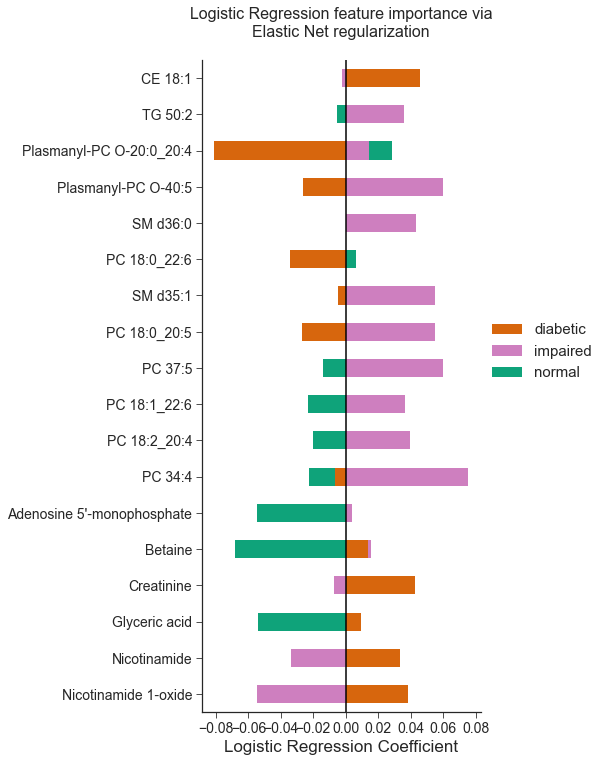

In [108]:
df = make_feature_importance_plot(lrcv_all, min_coef=0.033, column_names=['diabetic', 'impaired', 'normal'])
# df.loc[data['ID'] == 'Betaine', ]

[0.045 0.045 0.045] [0.1 0.1 0.1]
Total non-zero coefficients: 130
Num. non-zero coefficients
normal: 55
impaired: 49
diabetic: 61


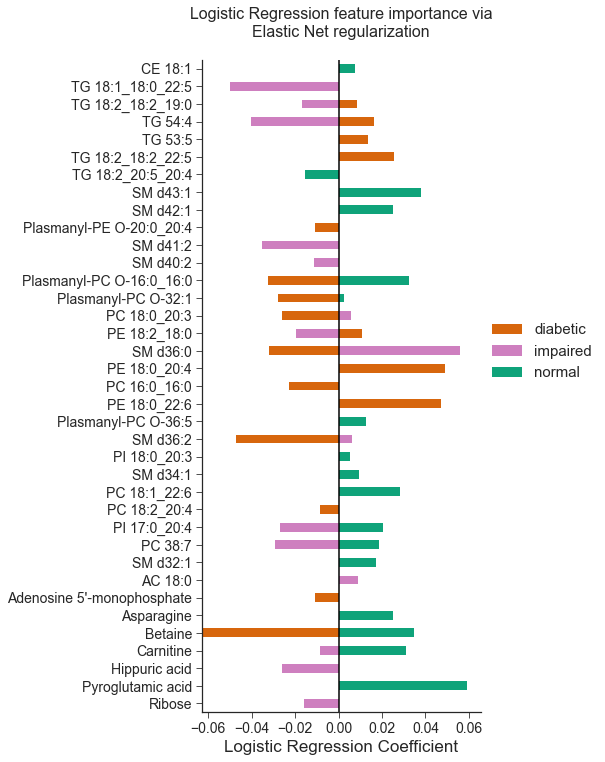

In [104]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
lrcv_rbg = LogisticRegressionCV(
    Cs=[0.045], 
    l1_ratios=[0.1],
    solver='saga',
    scoring='neg_log_loss',
    penalty='elasticnet',
    cv=rskf,
    max_iter=10000,
    n_jobs=-1,
    random_state=1,
)
lrcv_rbg.fit(X_zs.loc[rbg_cols], y_3class.loc[rbg_cols])

df = make_feature_importance_plot(lrcv_rbg, min_coef=0.005)

In [37]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
lrcv_fbg = LogisticRegressionCV(
    Cs=[0.045], 
    l1_ratios=[0.11],
    solver='saga',
    scoring='neg_log_loss',
    penalty='elasticnet',
    cv=rskf,
    max_iter=10000,
    n_jobs=-2,
    random_state=1,
)
lrcv_fbg.fit(X_zs.loc[fbg_cols], y_3class.loc[fbg_cols])

LogisticRegressionCV(Cs=[0.045],
                     cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
                     l1_ratios=[0.11], max_iter=10000, n_jobs=-2,
                     penalty='elasticnet', random_state=1,
                     scoring='neg_log_loss', solver='saga')

[0.045 0.045 0.045] [0.11 0.11 0.11]
Total non-zero coefficients: 148
Num. non-zero coefficients
normal: 85
impaired: 52
diabetic: 48


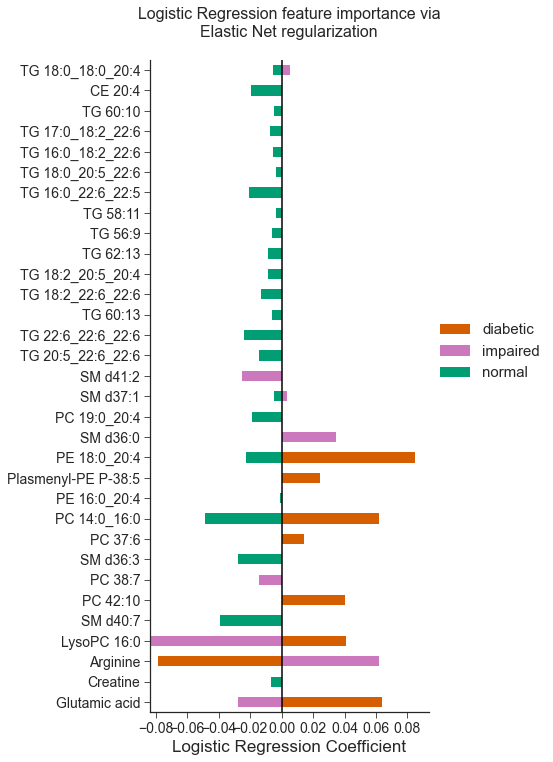

In [38]:
make_feature_importance_plot(lrcv_fbg)

## Try with 2 normals versus 8 diabetics (impaired and diabetic combined)

In [39]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
lrcv_rbg_2class = LogisticRegressionCV(
    Cs=[0.045], 
    l1_ratios=[0.12],
    solver='saga',
    scoring='neg_log_loss',
    penalty='elasticnet',
    cv=rskf,
    max_iter=10000,
    n_jobs=-1,
    random_state=1,
)
lrcv_rbg_2class.fit(X_zs.loc[rbg_cols], y_2class_N_ID.loc[rbg_cols])

LogisticRegressionCV(Cs=[0.045],
                     cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
                     l1_ratios=[0.12], max_iter=10000, n_jobs=-1,
                     penalty='elasticnet', random_state=1,
                     scoring='neg_log_loss', solver='saga')

[0.045] [0.12]
Total non-zero coefficients: 83


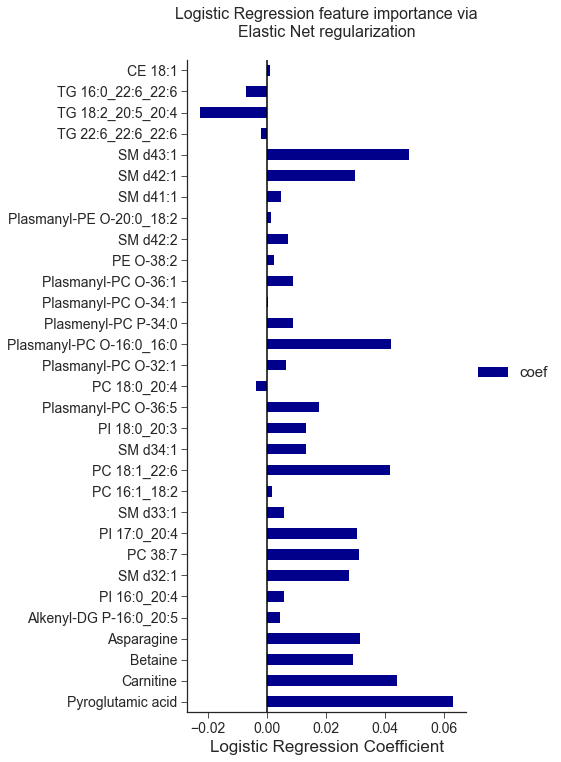

In [40]:
make_feature_importance_plot(lrcv_rbg_2class, )

In [41]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
lrcv_fbg_2class = LogisticRegressionCV(
    Cs=[0.045], 
    l1_ratios=[0.08],
    solver='saga',
    scoring='neg_log_loss',
    penalty='elasticnet',
    cv=rskf,
    max_iter=10000,
    n_jobs=-1,
    random_state=1,
)
lrcv_fbg_2class.fit(X_zs.loc[fbg_cols], y_2class_N_ID.loc[fbg_cols])

LogisticRegressionCV(Cs=[0.045],
                     cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
                     l1_ratios=[0.08], max_iter=10000, n_jobs=-1,
                     penalty='elasticnet', random_state=1,
                     scoring='neg_log_loss', solver='saga')

[0.045] [0.08]
Total non-zero coefficients: 129


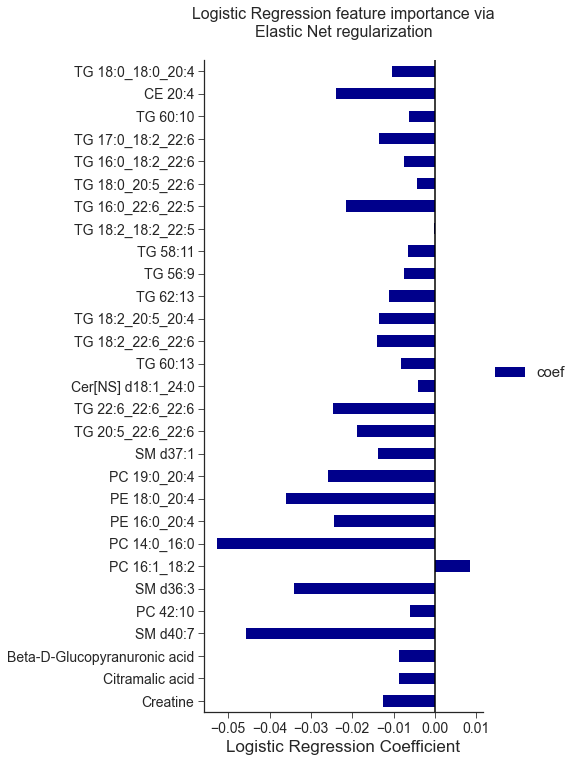

In [42]:
make_feature_importance_plot(lrcv_fbg_2class, )

## Try with subsets of data. 
### Drop normal data and only do I vs. D
### and drop impaired data, only do N vs. D

In [43]:
y_2class_I_D.index.intersection(fbg_cols)

Index(['1060_8_FBG', '1060_9_FBG', '1060_10_FBG', '1062_8_FBG', '1062_9_FBG',
       '1062_10_FBG', '1074_8_FBG', '1074_9_FBG', '1074_10_FBG', '1092_8_FBG',
       '1092_9_FBG', '1092_10_FBG', '1102_8_FBG', '1102_9_FBG', '1102_10_FBG',
       '1076_8_FBG', '1076_9_FBG', '1076_10_FBG', '1082_8_FBG', '1082_9_FBG',
       '1082_10_FBG', '1101_8_FBG', '1101_9_FBG', '1101_10_FBG'],
      dtype='object', name='combined_col_name')

In [44]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
lrcv_fbg_2class_I_D = LogisticRegressionCV(
    Cs=[0.045], 
    l1_ratios=[0.08],
    solver='saga',
    scoring='neg_log_loss',
    penalty='elasticnet',
    cv=rskf,
    max_iter=10000,
    n_jobs=-1,
    random_state=1,
)
lrcv_fbg_2class_I_D.fit(X_zs.loc[fbg_cols.intersection(y_2class_I_D.index)],  # note the intersection of indexes
                    y_2class_I_D.loc[fbg_cols.intersection(y_2class_I_D.index)])

LogisticRegressionCV(Cs=[0.045],
                     cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
                     l1_ratios=[0.08], max_iter=10000, n_jobs=-1,
                     penalty='elasticnet', random_state=1,
                     scoring='neg_log_loss', solver='saga')

In [81]:
data.loc[(data['ID'] != 'unknown') & (data['Type'] == 'metabolite')].iloc[40:]

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,qval_sampling:ogtt,qval_insulin,qval_weight,pval_sampling,pval_week,pval_litter,pval_ogtt,pval_sampling:ogtt,pval_insulin,pval_weight
i,,,,,,,,,,,,,,,,,,,,,
m_110,Hippuric acid_7.887_178.04995,7.887,178.04995,[M-H]-1,metabolite,-,Hippuric acid,21.943017,21.520301,18.814443,...,0.710870,0.998551,0.919886,5.226169e-15,0.501172,1.169680e-01,0.884482,0.613754,0.959218,0.691119
m_111,Iditol_10.884_181.07085,10.884,181.07085,[M-H]-1,metabolite,-,Iditol,20.200436,18.720596,19.146712,...,0.065729,0.998551,0.821817,2.877995e-10,0.151794,2.254101e-05,0.147292,0.026589,0.384590,0.484451
m_113,Hexose sugar_10.241_179.05518,10.241,179.05518,[M-H]-1,metabolite,-,Hexose sugar,20.008133,17.544230,16.484990,...,0.164003,0.998551,0.957084,4.395760e-02,0.944451,4.877465e-02,0.936740,0.083664,0.777269,0.864884
m_117,Guanidinosuccinic acid_9.3_176.06582,9.300,176.06582,[M+H]+1,metabolite,+,Guanidinosuccinic acid,22.568932,21.864883,19.719137,...,0.062639,0.998551,0.981228,2.303491e-03,0.812099,8.806646e-01,0.173420,0.025077,0.966033,0.957726
m_120,Glyceric acid_11.985_105.01821,11.985,105.01821,[M-H]-1,metabolite,-,Glyceric acid,23.231591,23.350983,22.792579,...,0.164003,0.998551,0.625147,8.302855e-02,0.671435,1.092176e-01,0.000924,0.083836,0.297342,0.236250
m_121,Glutamine_12.628_145.06082,12.628,145.06082,[M-H]-1,metabolite,-,Glutamine,27.730627,28.158148,27.878989,...,0.015683,0.998551,0.969715,3.075441e-01,0.280516,5.966817e-02,0.054689,0.004643,0.156450,0.915507
m_122,Glutamic acid_13.766_148.0605,13.766,148.06050,[M+H]+1,metabolite,+,Glutamic acid,22.327850,21.402174,21.483932,...,0.494766,0.998551,0.908753,8.081966e-01,0.720106,2.564460e-01,0.783924,0.376259,0.728546,0.658237
m_123,Glucose_11.565_179.05517,11.565,179.05517,[M-H]-1,metabolite,-,Glucose,26.093479,24.946258,24.291475,...,0.000252,0.998551,0.805280,4.111779e-10,0.276993,1.097879e-03,0.555850,0.000009,0.448529,0.460544
m_124,unknown_13.671_195.05013,13.671,195.05013,[M-H]-1,metabolite,-,Gluconic acid,21.437088,21.089572,21.277538,...,0.654083,0.998551,0.839190,4.969986e-01,0.177142,9.793594e-02,0.065414,0.540935,0.274701,0.510884


[0.045] [0.08]
Total non-zero coefficients: 84


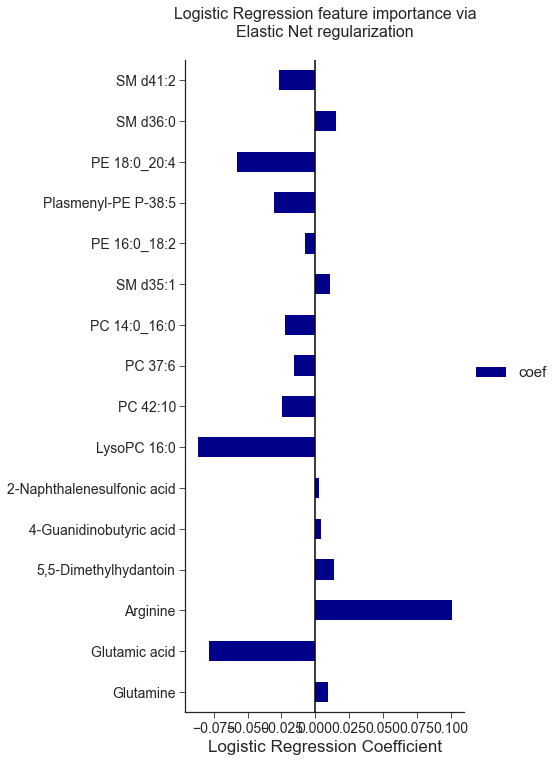

In [45]:
make_feature_importance_plot(lrcv_fbg_2class_I_D, )

In [50]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
lrcv_rbg_2class_I_D = LogisticRegressionCV(
    Cs=[0.045], 
    l1_ratios=[0.08],
    solver='saga',
    scoring='neg_log_loss',
    penalty='elasticnet',
    cv=rskf,
    max_iter=10000,
    n_jobs=-1,
    random_state=1,
)
lrcv_rbg_2class_I_D.fit(X_zs.loc[rbg_cols.intersection(y_2class_I_D.index)],  # note the intersection of indexes
                    y_2class_I_D.loc[rbg_cols.intersection(y_2class_I_D.index)])

LogisticRegressionCV(Cs=[0.045],
                     cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
                     l1_ratios=[0.08], max_iter=10000, n_jobs=-1,
                     penalty='elasticnet', random_state=1,
                     scoring='neg_log_loss', solver='saga')

[0.045] [0.08]
Total non-zero coefficients: 109


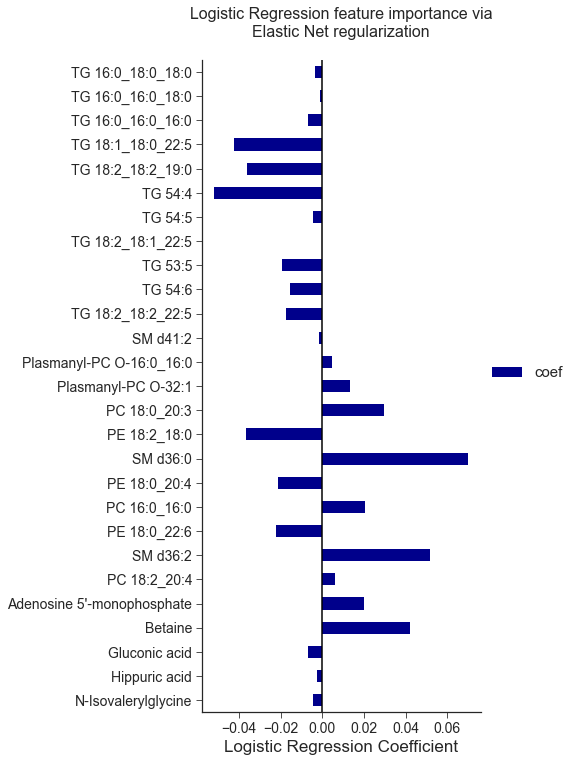

In [51]:
make_feature_importance_plot(lrcv_rbg_2class_I_D)

[0.045] [0.08]
Total non-zero coefficients: 97


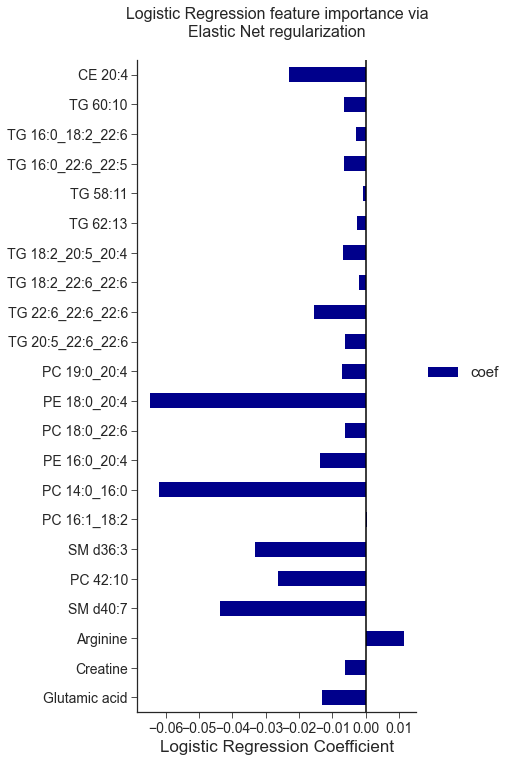

In [52]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
lrcv_fbg_2class_N_D = LogisticRegressionCV(
    Cs=[0.045], 
    l1_ratios=[0.08],
    solver='saga',
    scoring='neg_log_loss',
    penalty='elasticnet',
    cv=rskf,
    max_iter=10000,
    n_jobs=-1,
    random_state=1,
)
lrcv_fbg_2class_N_D.fit(
    X_zs.loc[fbg_cols.intersection(y_2class_N_D.index)],  # note the intersection of indexes
    y_2class_N_D.loc[fbg_cols.intersection(y_2class_N_D.index)])

make_feature_importance_plot(lrcv_fbg_2class_N_D)

[0.045] [0.08]
Total non-zero coefficients: 111


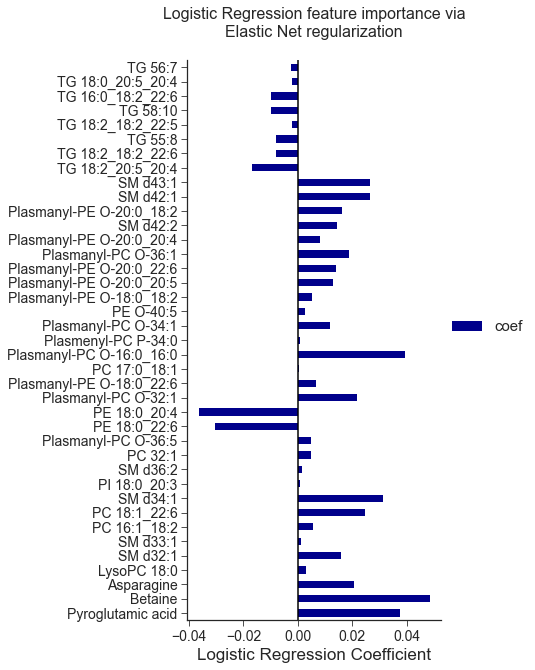

In [56]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)
lrcv_rbg_2class_N_D = LogisticRegressionCV(
    Cs=[0.045], 
    l1_ratios=[0.08],
    solver='saga',
    scoring='neg_log_loss',
    penalty='elasticnet',
    cv=rskf,
    max_iter=10000,
    n_jobs=-1,
    random_state=1,
)
lrcv_rbg_2class_N_D.fit(
    X_zs.loc[rbg_cols.intersection(y_2class_N_D.index)],  # note the intersection of indexes
    y_2class_N_D.loc[rbg_cols.intersection(y_2class_N_D.index)])

make_feature_importance_plot(lrcv_rbg_2class_N_D)
# plt.gca().set_title('hi')
# plt.ylim(0, 20)
plt.tight_layout()
plt.gcf().set_size_inches(18, 9)
# plt.savefig(r'..\reports\figures\logreg.png', dpi=600)

### Fully training with n_repeats=10 takes about 20 mins

Regularization (C) and L1 parameters for each class) [0.04641589 0.04641589 0.04641589] [0.3 0.3 0.3]


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (2).

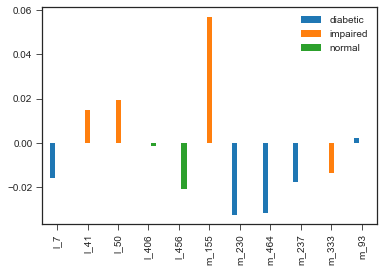

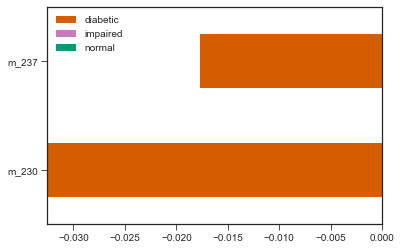

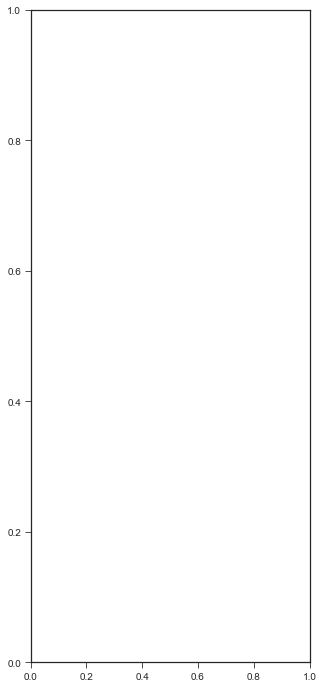

In [10]:
for lrcv in [lrcv_rbg, lrcv_fbg]:
    print('Regularization (C) and L1 parameters for each class)', lrcv.C_, lrcv.l1_ratio_)
    ldf = pd.DataFrame(lrcv.coef_, columns=lrcv.feature_names_in_, index=lrcv.classes_).T

    # df[(df.values > 1.5).any(1)]
    nzc = ldf.loc[(ldf != 0).any(axis=1)]  # nzc = non-zero coefficients 
    nzc.plot.bar()
    filt = nzc.loc[(abs(nzc) > 0.015).any(axis=1)]
    len(filt)
    nzc_ids = data.loc[filt.loc[data['Proposed ID'] != 'unknown'].index, 'Proposed ID']
    nzc_ids
    filt.loc[data['Proposed ID'] != 'unknown'].plot.barh(stacked=True, color=colors)
    
    plt.figure()
    plt.gcf().set_size_inches(5, 12)
    plt.yticks(plt.yticks()[0], nzc_ids, fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel('Logistic Regression Coefficient', fontsize=17)
    plt.title('')
    plt.axvline(color='black')
    plt.legend(loc=(1.02, 0.5), fontsize=15, markerscale=2)
    sns.despine()
    plt.gcf().set_facecolor('white')

In [79]:
nzc_ids

m_230     4-Oxoproline
m_237    Urocanic acid
Name: Proposed ID, dtype: object

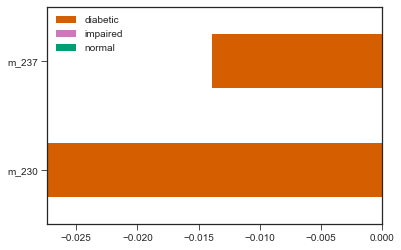

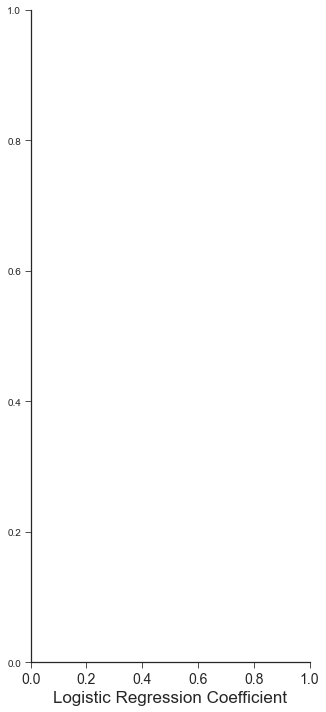

In [81]:
ldf_rbg = pd.DataFrame(lrcv_rbg.coef_, columns=lrcv_rbg.feature_names_in_, index=lrcv_rbg.classes_).T

# df[(df.values > 1.5).any(1)]
nzc = ldf_rbg.loc[(ldf_rbg != 0).any(axis=1)]  # nzc = non-zero coefficients 
# nzc.plot.bar()
filt = nzc.loc[(abs(nzc) > 0.00).any(axis=1)]
len(filt)
nzc_ids = data.loc[filt.loc[data['Proposed ID'] != 'unknown'].index, 'Proposed ID']
# nzc_ids
filt.loc[data['Proposed ID'] != 'unknown'].plot.barh(stacked=True, color=colors)

plt.figure()
plt.gcf().set_size_inches(5, 12)
# plt.yticks(plt.yticks()[0], nzc_ids, fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Logistic Regression Coefficient', fontsize=17)
plt.title('')
plt.axvline(color='black')
# plt.legend(loc=(1.02, 0.5), fontsize=15, markerscale=2)
sns.despine()
plt.gcf().set_facecolor('white')

[0.04641589 0.04641589 0.04641589] [0.3 0.3 0.3]


IndexError: index 0 is out of bounds for axis 0 with size 0

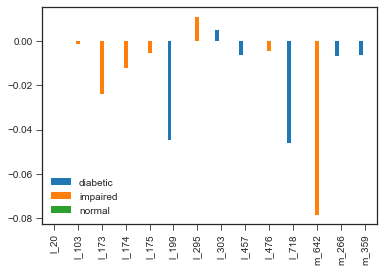

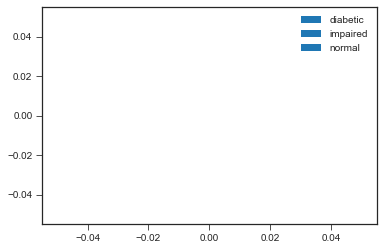

In [82]:
ldffbg = pd.DataFrame(lrcv_fbg.coef_, columns=lrcv_fbg.feature_names_in_, index=lrcv_fbg.classes_).T
print(lrcv_fbg.C_, lrcv_fbg.l1_ratio_)
# df[(df.values > 1.5).any(1)]
nzc = ldffbg.loc[(ldffbg != 0).any(axis=1)]  # nzc = non-zero coefficients 
nzc.plot.bar()
filt = nzc.loc[(abs(nzc) > 0.00).any(axis=1)]
# len(filt)
nzc_ids = data.loc[filt.loc[data['Proposed ID'] != 'unknown'].index, 'Proposed ID']
# nzc_ids
filt.loc[data['Proposed ID'] != 'unknown'].plot.barh(stacked=True, color=colors)

In [35]:
len(lrcv.scores_['diabetic'])

60

In [48]:
nzc

,diabetic,impaired,normal
l_7,-0.016168,0.000000,0.000000
l_41,0.000000,0.014662,0.000000
l_50,0.000000,0.019571,0.000000
l_406,0.000000,0.000000,-0.001627
l_456,0.000000,0.000000,-0.020838
m_155,0.000000,0.057021,0.000000
m_230,-0.032526,0.000000,0.000000
m_464,-0.031944,0.000000,0.000000
m_237,-0.017748,0.000000,0.000000
m_333,0.000000,-0.013708,0.000000


<AxesSubplot:>

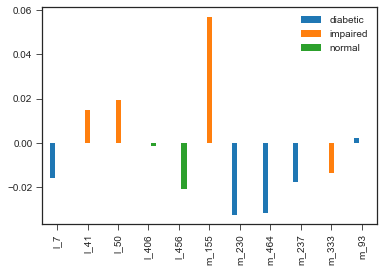

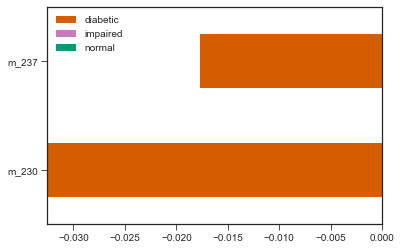

In [46]:
ldfall = pd.DataFrame(lrcv.coef_, columns=lrcv.feature_names_in_, index=lrcv.classes_).T

# df[(df.values > 1.5).any(1)]
nzc = ldfall.loc[(ldfall != 0).any(axis=1)]  # nzc = non-zero coefficients 
nzc.plot.bar()
filt = nzc.loc[(abs(nzc) > 0.00).any(axis=1)]
len(filt)
nzc_ids = data.loc[filt.loc[data['Proposed ID'] != 'unknown'].index, 'Proposed ID']
# nzc_ids
filt.loc[data['Proposed ID'] != 'unknown'].plot.barh(stacked=True, color=colors)

# plt.figure()
# plt.gcf().set_size_inches(5, 12)
# plt.yticks(plt.yticks()[0], nzc_ids, fontsize=14)
# plt.xticks(fontsize=14)
# plt.xlabel('Logistic Regression Coefficient', fontsize=17)
# plt.title('')
# plt.axvline(color='black')
# plt.legend(loc=(1.02, 0.5), fontsize=15, markerscale=2)
# sns.despine()
# plt.gcf().set_facecolor('white')